In [1]:
import numpy as np
from definitions import path_join, make_directory, EXPERIMENTS_DIR, VENSIM_MODELS_DIR, logging

In [2]:
KNOWN_MODEL = 'known model'
UNKNOWN_MODEL = 'unknown model'

In [3]:
model_name = 'predator_prey'
experiment_name = '{}_links_recovery_full'.format(model_name)

mode = UNKNOWN_MODEL
need_retrain = False

In [4]:
import tensorflow as tf

general_params = {
    'phi_h': tf.keras.activations.linear,
    'phi_o': tf.keras.activations.linear,
}

train_params = {
    'learning_rate': 1e-1,
    'epochs_before_decay': 0.1,
    'epochs_count': 50,
    'learning_rate_decay': 1/3,
    'iterations_count': 300,
}

In [5]:
def create_experiment_enviroment(model_name, experiment_name, mode):
    experiment_settings = dict()
    
    experiment_settings['model_name'] = model_name
    experiment_settings['experiment_name'] = experiment_name
    experiment_settings['mode'] = mode
    
    experiment_dir = path_join(EXPERIMENTS_DIR, experiment_name)
    make_directory(experiment_dir)
    experiment_settings['experiment_dir'] = experiment_dir
    
    tf_model_dir = path_join(experiment_dir, 'tf_model')
    make_directory(tf_model_dir)
    experiment_settings['tf_model_dir'] = tf_model_dir
    
    images_dir = path_join(experiment_dir, 'images')
    make_directory(images_dir)
    experiment_settings['images_dir'] = images_dir
    
    log_path = path_join(experiment_dir, 'log.log')
    logging.basicConfig(filename=log_path, level=logging.INFO)
    experiment_settings['log_path'] = log_path

    vensim_model_file = path_join(VENSIM_MODELS_DIR, '{}.mdl'.format(model_name))
    experiment_settings['vensim_model_file'] = vensim_model_file
    
    prn_model_dir = path_join(tf_model_dir, 'prn_model')
    nn_model_dir = path_join(tf_model_dir, 'base_nn_model')
    nn_2l_model_dir = path_join(tf_model_dir, 'nn_2l_model')
    make_directory(prn_model_dir)
    make_directory(nn_model_dir)
    make_directory(nn_2l_model_dir)
    
    experiment_settings['prn_model_dir'] = prn_model_dir
    experiment_settings['nn_model_dir'] = nn_model_dir
    experiment_settings['nn_2l_model_dir'] = nn_2l_model_dir

    return experiment_settings
    
experiment_settings = create_experiment_enviroment(model_name, experiment_name, mode)

In [6]:
from definitions import path_join, DATA_DIR

dataset_dir = path_join(DATA_DIR, model_name)
dataset_file = path_join(dataset_dir, 'dataset_2000.csv')

In [7]:
import pandas as pd

data = pd.read_csv(dataset_file)
dt = 0.03125
stopwords = ['TIME', 'sim_index']
fields = [column for column in data.columns if column not in stopwords]

In [8]:
from module.fd_model.vensim_fd_converter import create_unknown_model

FD = create_unknown_model(fields)
FD.dT = dt

print('dt: {}'.format(dt))

dt: 0.03125


In [9]:
fields = [level for level in FD.names_units_map.keys()]
fields

['Predator Population',
 'Prey Population',
 'predator birth fraction',
 'predator death proportionality constant',
 'prey birth fraction',
 'prey death proportionality constant']

In [10]:
from sklearn.model_selection import train_test_split


def np_preproc_for_rnn3d(numpy_array, fields):
    x_groups = [group[1][fields].values[:-1] for group in numpy_array]
    y_groups = [group[1][fields].values[1:] for group in numpy_array]
    
    train_X, valid_X, train_y, valid_y = train_test_split(x_groups, y_groups, test_size=0.2, random_state=123)
    
    train_X = np.concatenate(train_X, axis=0)
    valid_X = np.concatenate(valid_X, axis=0)
    
    train_y = np.concatenate(train_y, axis=0)
    valid_y = np.concatenate(valid_y, axis=0)

    return (train_X, train_y), (valid_X, valid_y)


def generate_train_data(df, fields):
    dataset = df[fields].values
    grouped = df.groupby(['sim_index'])[fields]
    
    return dataset, np_preproc_for_rnn3d(grouped, fields)

In [11]:
_, (prn_train, prn_valid) = generate_train_data(data, fields)

In [12]:
prn_train_X, prn_train_y = prn_train
prn_valid_X, prn_valid_y = prn_valid

In [13]:
import tensorflow as tf
from tensorflow.python.framework import ops

ops.reset_default_graph()

In [14]:
from module.fd_model.fd_rnn_converter import FDRNNConverter
# from module.nn_model import NNModel as NNModelv1
from module.nn_model_tf_v2 import NNModel as NNModelv2
# from module.nn_model_with_regularizer import NNModel as NNModelv3
from module.nn_model_tf_v3 import NNModel as NNModelv3
from module.nn_model_tf_v21 import NNModel as NNModelv21

choosed_model = NNModelv2

In [15]:
FDRNN_converter = FDRNNConverter(general_params['phi_h'], general_params['phi_o'])
rnn_model = FDRNN_converter.fd_to_rnn(FD, choosed_model)

In [16]:
FD.levels
# FD.constants
# FD.rates

['Predator Population',
 'Prey Population',
 'predator birth fraction',
 'predator death proportionality constant',
 'prey birth fraction',
 'prey death proportionality constant']

In [17]:
initial_value = np.reshape(prn_valid_X[0], [1, prn_valid_X.shape[1]])
initial_value

array([[7.50e+01, 1.00e+02, 2.00e-02, 1.04e+00, 1.75e+00, 3.50e-02]])

In [18]:
iterations_count = train_params['iterations_count']
if iterations_count == 0:
    iterations_count = X.shape[0] - 1
iterations_count

300

In [19]:
rnn_model.load(experiment_settings['prn_model_dir'])

In [20]:
prn_iterative = rnn_model.get_simulation(initial_value, iterations_count, experiment_settings['prn_model_dir'])

In [21]:
prn_iterative.shape

(301, 6)

In [22]:
from arch.base_nn import BaseNN

predictor = BaseNN(prn_train_X.shape[1], prn_train_X.shape[1])

In [23]:
nn_iterative = predictor.get_simulation(initial_value, iterations_count, experiment_settings['nn_model_dir'])

In [24]:
from arch.base_nn_2layers import BaseNN2Layers

nn_2l_predictor = BaseNN2Layers(prn_train_X.shape[1], prn_train_X.shape[1])

In [25]:
nn_2l_iterative = nn_2l_predictor.get_simulation(initial_value, iterations_count, experiment_settings['nn_2l_model_dir'])

In [26]:
nn_2l_test = nn_2l_predictor.test(prn_train_X[:iterations_count], experiment_settings['nn_2l_model_dir'])

In [27]:
import matplotlib.pyplot as plt

SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

<Figure size 432x288 with 0 Axes>

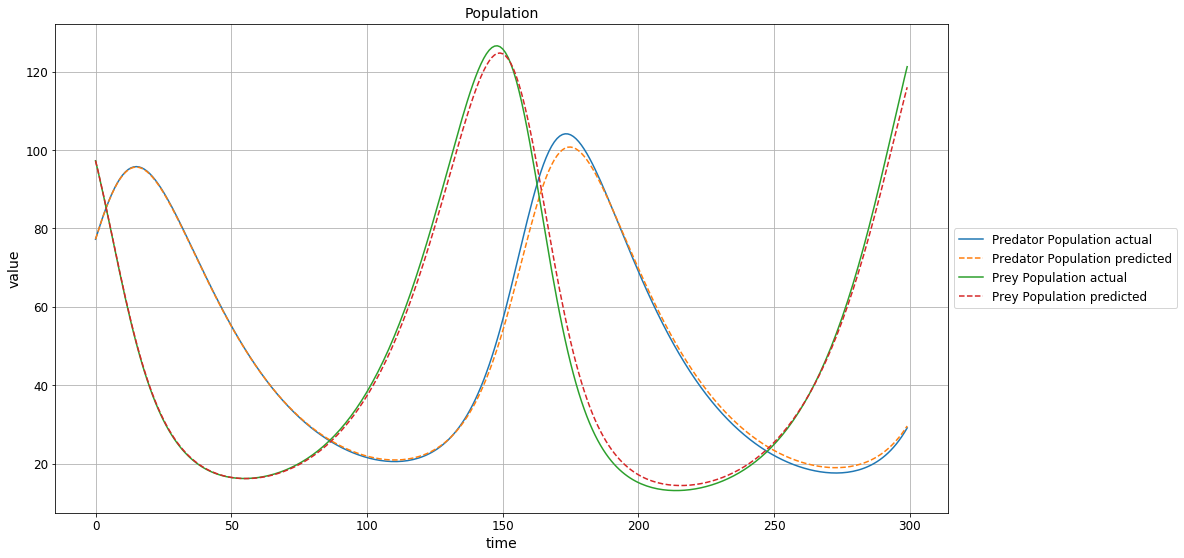

In [29]:
plt.clf()

plt.figure(figsize=(16, 9))


plt.title('Population')
plt.xlabel('time')
plt.ylabel('value')
column = 0
plt.plot(prn_valid_y[:iterations_count, column], label='{} actual'.format(fields[column]))
plt.plot(prn_iterative[1:, column], label='{} predicted'.format(fields[column]), linestyle='--')
column = 1
plt.plot(prn_valid_y[:iterations_count, column], label='{} actual'.format(fields[column]))
plt.plot(prn_iterative[1:, column], label='{} predicted'.format(fields[column]), linestyle='--')
# plt.plot(nn_2l_test[:, column], label='NN predicted')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

<Figure size 432x288 with 0 Axes>

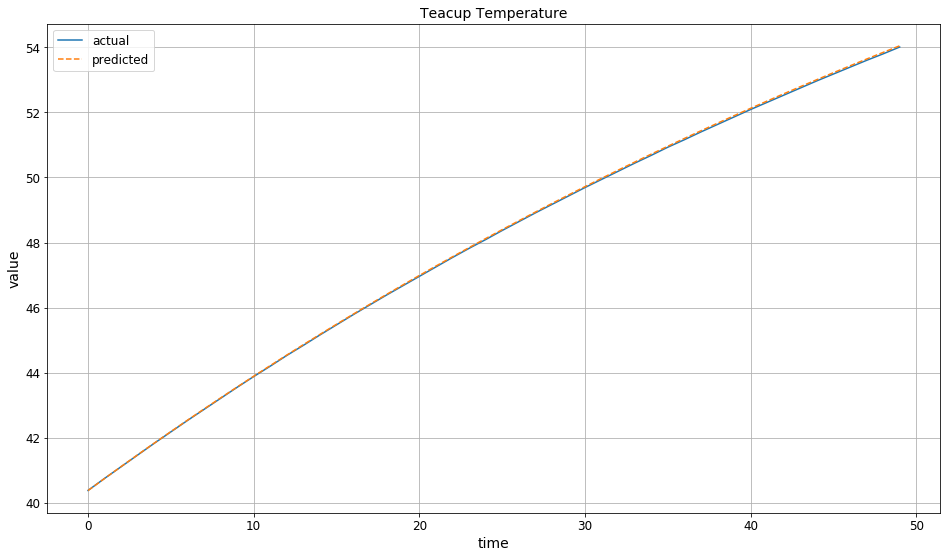

In [28]:
plt.clf()

plt.figure(figsize=(16, 9))
column = 2

plt.title(fields[column])
plt.xlabel('time')
plt.ylabel('value')
plt.plot(prn_valid_y[:iterations_count, column], label='actual')
plt.plot(prn_iterative[1:, column], label='predicted', linestyle='--')
# plt.plot(nn_2l_test[:, column], label='NN predicted')
plt.grid()
plt.legend()

In [30]:
nn_2l_test

array([[5.11117897e+01, 4.65991631e+01, 1.21053103e-02, 1.02309847e+00,
        1.49750280e+00, 8.39316566e-03],
       [5.04028893e+01, 4.77030258e+01, 1.21698081e-02, 1.02312672e+00,
        1.49708855e+00, 8.38704314e-03],
       [4.97276039e+01, 4.88506927e+01, 1.22359805e-02, 1.02315640e+00,
        1.49668598e+00, 8.38022772e-03],
       ...,
       [1.60346085e+02, 2.54133224e+01, 9.49681178e-03, 1.02309608e+00,
        1.54914141e+00, 7.81521015e-03],
       [1.56612930e+02, 2.46468811e+01, 9.51259024e-03, 1.02305257e+00,
        1.54749870e+00, 7.85018969e-03],
       [1.52928497e+02, 2.39492989e+01, 9.53106023e-03, 1.02301145e+00,
        1.54587269e+00, 7.88411219e-03]], dtype=float32)

<Figure size 432x288 with 0 Axes>

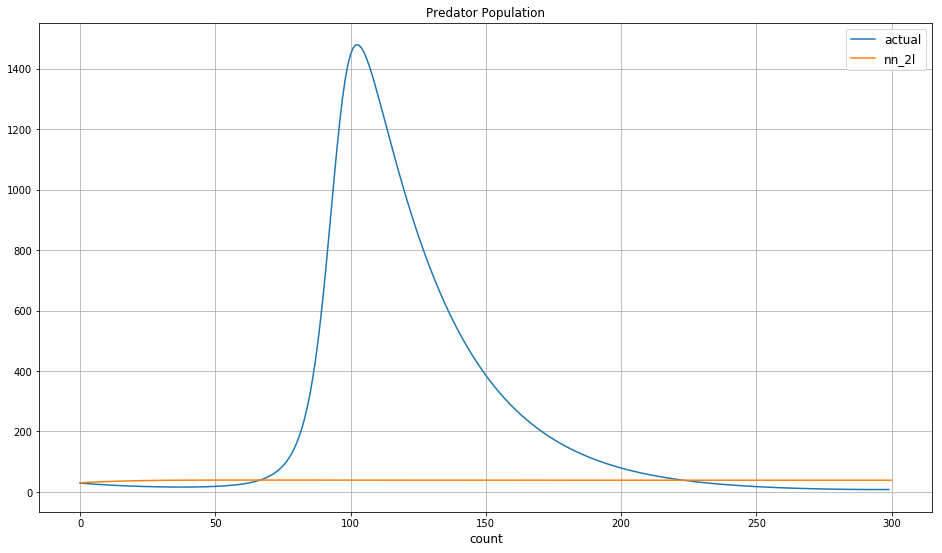

In [33]:
import matplotlib.pyplot as plt

plt.clf()

plt.figure(figsize=(16, 9))
column = 0

plt.title(fields[column])
plt.xlabel('time')
plt.xlabel('count')
plt.plot(prn_valid_y[:iterations_count, column], label='actual')
# plt.plot(prn_iterative[:, column], label='predicted')
plt.plot(nn_2l_iterative[:, column], label='nn_2l')
plt.grid()
plt.legend()

In [35]:
import tensorflow as tf

In [30]:
def parse_weights(gate, w, fields):
    equations = []
    for col_idx in range(gate.shape[1]):
        equation = ''
        for row_idx in range(gate.shape[0]):
            if (w[row_idx, col_idx] == 0):
                continue
            if gate[row_idx, col_idx] == 0:
                sign = '*' if w[row_idx, col_idx] > 0 else '/'
                weight = np.abs(w[row_idx, col_idx])
                weight = '' if weight == 1 else weight
                equation += '{}{}{}'.format(sign, weight, fields[row_idx])
        for row_idx in range(gate.shape[0]):
            if (w[row_idx, col_idx] == 0):
                continue
            if gate[row_idx, col_idx] == 1:
                sign = '+' if w[row_idx, col_idx] > 0 else '-'
                weight = np.abs(w[row_idx, col_idx])
                weight = '' if weight == 1 else weight
                equation += '{}{}{}'.format(sign, weight, fields[row_idx])

        equations.append(equation)
    return equations

In [31]:
_gate = np.array(tf.round(rnn_model.model.gate), dtype=np.int32)
_w = np.array(tf.round(rnn_model.model.W_ah), dtype=np.int32)
# print(fields)
parse_weights(_gate, _w, fields)

['', '', '', '', '', '/Characteristic Time']

In [32]:
tf.round(tf.math.sigmoid(rnn_model.model.gate))

<tf.Tensor: shape=(3, 6), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1., 1.]], dtype=float32)>

In [33]:
import pickle

file_name = path_join(experiment_settings['nn_2l_model_dir'], 'loss_history')
print(file_name)
with open(file_name, 'rb') as file:
    prn_train_data = pickle.load(file)

C:\Users\HWer\Documents\GitHub\SDtoPRN\experiments\teacup_recovery\tf_model\nn_2l_model\loss_history


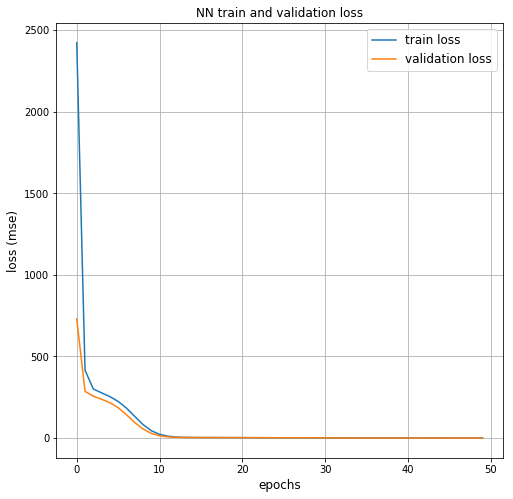

In [39]:
import matplotlib.pyplot as plt
import pickle
import os

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.figure(figsize=(8, 8))
plt.plot(prn_train_data['loss'], label='train loss')
plt.plot(prn_train_data['val_loss'], label='validation loss')

plt.xlabel('epochs')
plt.ylabel('loss (mse)')

# plt.xlim(0)
# plt.ylim(0)
# y_ticks = [10 ** i for i in range(-10, 5)]

title = 'NN train and validation loss'
plt.title(title)

# plt.yscale('log')
plt.legend()
plt.grid()
# plt.savefig(os.path.join(images_dir, title))

In [29]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def biplot(x, y, title, model_name, images_dir):
    plt.figure(figsize=(8, 8))
    plt.scatter(x, y)
    plt.grid()

#     min_ylim = min(min(x), min(y))
#     max_ylim = max(max(x), max(y))

#     plt.ylim(min_ylim, max_ylim)

    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(title)

    # plt.show()
#     image_path = path_join(images_dir, title + '.png')
#     plt.savefig(image_path)
#     plt.gcf().clear()

(50,)
(50,)
(50,)
(50,)
(50,)
(50,)


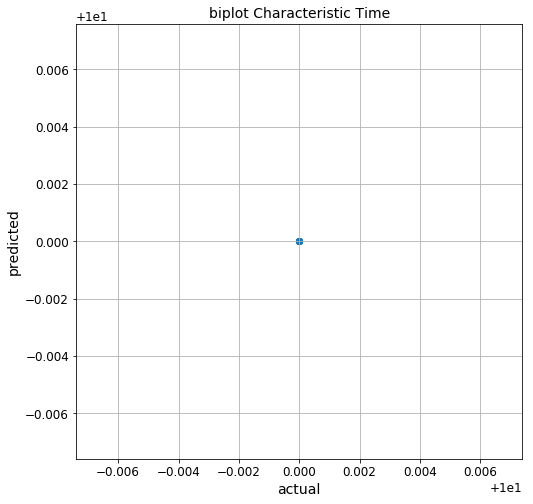

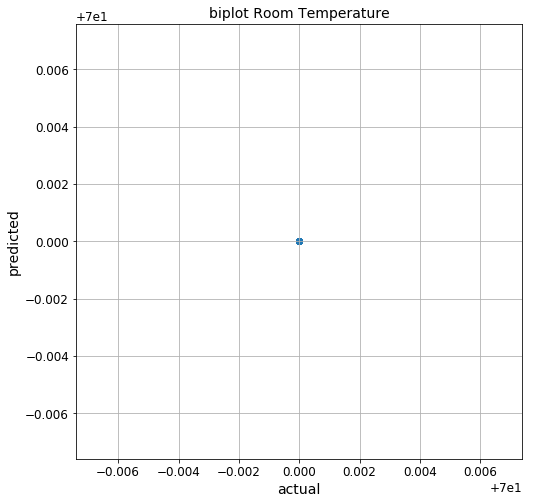

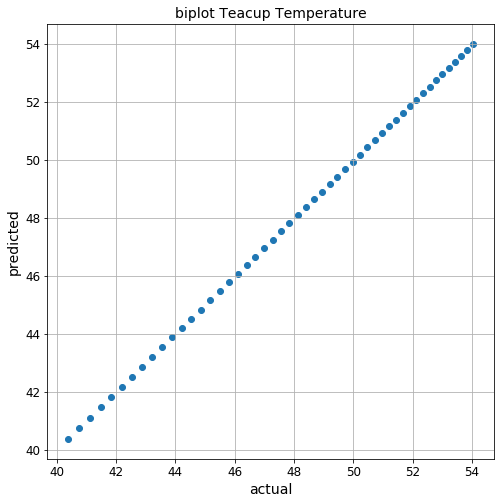

In [30]:
for level in fields:
    import matplotlib.pyplot as plt

    SMALL_SIZE = 8
    MEDIUM_SIZE = 12
    BIGGER_SIZE = 14

    plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    i = fields.index(level)
    level_output = prn_iterative[1:, i]
    level_y = prn_valid_y[:iterations_count, i]
    print(level_output.shape)
    print(level_y.shape)
#     graphs = (level_output, level_nn_output, level_y)
#     labels = ('PRN_y', 'NN_y', 'true_y')

#     biplot_name1 = 'biplot {} NN and SD simulation'.format(level)
#     biplot(level_nn_output, level_y, biplot_name1, 'NN', images_dir)
    
#     biplot_name2 = 'biplot {} PRN and SD simulation'.format(level)
#     biplot(level_output, level_y, biplot_name2, 'PRN', images_dir)
#     graph_name = 'graph {} SD and PRN graphs'.format(level)
    biplot_name2 = 'biplot {}'.format(level)
    biplot(level_output, level_y, biplot_name2, 'NN', None)

    

#     plot_graphs(graphs, labels, '{} ({})'.format(model_name, level), images_dir)